In [21]:
import numpy as np
import torch.nn as nn
import torch
import torchvision

import matplotlib.pyplot as plt
from IPython import display
import torch.nn.functional as F
from copy import deepcopy
from torch.utils.data import DataLoader

from utils import tensor_list_prod, make_random_affine_dependency_dataset
from models import linearNN, linearNN_with_activation, linearNN_dropout
from utils import NoisyDataset

device = 'cpu'

In [37]:
def validate(loss_history, rank_history, verbose_interval):
        axis = range(0, verbose_interval * len(loss_history), verbose_interval)
        plt.style.use('ggplot')
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax1.plot(axis, loss_history)
        ax1.set_title('Loss')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('$||\hat{y} - y||_2$')
        ax2.plot(axis, rank_history)
        ax2.set_title('Rank evolution')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('rank')
        plt.show()

def train_nn(net, opt, loader, criterion, 
             with_noise=False, sigma_noise=0.1,
             num_epochs=500, verbose_interval=50, tol=1e-3):
    
    loss_history = []
    rank_history = []
    for epoch in range(num_epochs):
        for (batch, answer) in loader:
            opt.zero_grad()
            pred = net.to(device).forward(batch.to(device))
            loss = criterion(pred, answer.to(device))
            loss.backward()
            if with_noise: 
                for param in net.parameters():
                    param.grad += torch.randn_like(param.grad) * sigma_noise
            opt.step()    
        
        
        if epoch % verbose_interval == 0:
            rank = torch.matrix_rank(tensor_list_prod(list(net.parameters())))
            rank_history.append(rank)
            loss_history.append(loss.item())
            display.clear_output(wait=True)
            print('Epoch:', epoch)
            validate(loss_history, rank_history, verbose_interval)
            
        if loss_history[-1] < tol:
            print('Early stop activated!')
            break
    return loss_history, rank_history

Now, let's consider $X$ to have `1000` dimensions, $Y$ to have `250` dimensions and $1000$ data points

In [31]:
torch.manual_seed(42)
np.random.seed(42)
num_points=1000 
x_size=1000
y_size=250

data, R = make_random_affine_dependency_dataset(num_points, x_size, y_size, device=device)
net = linearNN(x_size, y_size, widths=[250,], init=10).to(device)

Now, let's consider the `GD` training without noise

In [24]:
net_gd = deepcopy(net)
opt = torch.optim.SGD(net_gd.parameters(), lr=1e-2)
criterion = nn.MSELoss()
loader = DataLoader(data, batch_size=num_points, drop_last=False)

Epoch: 2950


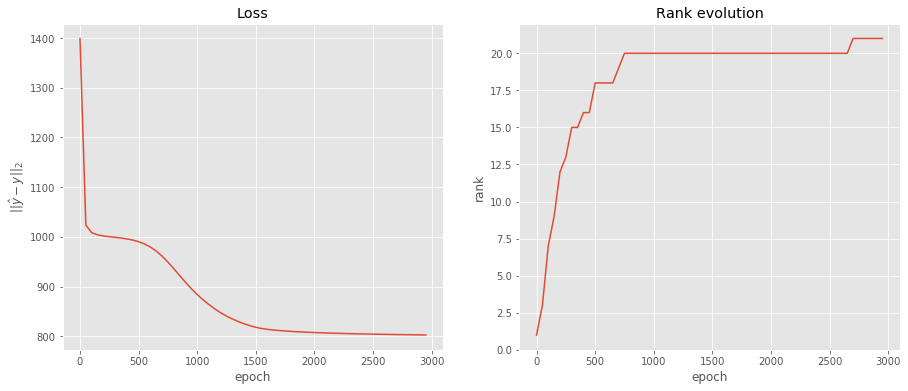

In [10]:
loss_hist_gd, rank_hist_gd = train_nn(net_gd, opt, loader, criterion, num_epochs=3000, with_noise=False, sigma_noise=20.)

Now, let's consider `GD` training with noise

In [13]:
net_gd_ns = deepcopy(net)
opt = torch.optim.SGD(net_gd_ns.parameters(), lr=1e-2)
criterion = nn.MSELoss()
loader = DataLoader(data, batch_size=num_points, drop_last=False)

Epoch: 2950


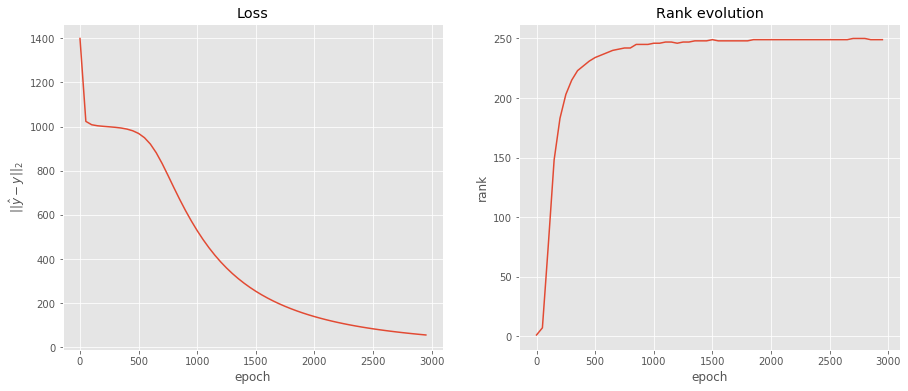

In [14]:
loss_hist_gd_ns, rank_hist_gd_ns = train_nn(net_gd_ns, opt, loader, criterion, num_epochs=3000, with_noise=True, sigma_noise=0.04)

Let's consider $X$ with noise

In [42]:
net_x = deepcopy(net)
opt = torch.optim.SGD(net_x.parameters(), lr=1e-2)
data_x = NoisyDataset('x', data, 1.)
# data_x = data
criterion = nn.MSELoss()
loader = DataLoader(data_x, batch_size=num_points, drop_last=False)

Epoch: 0


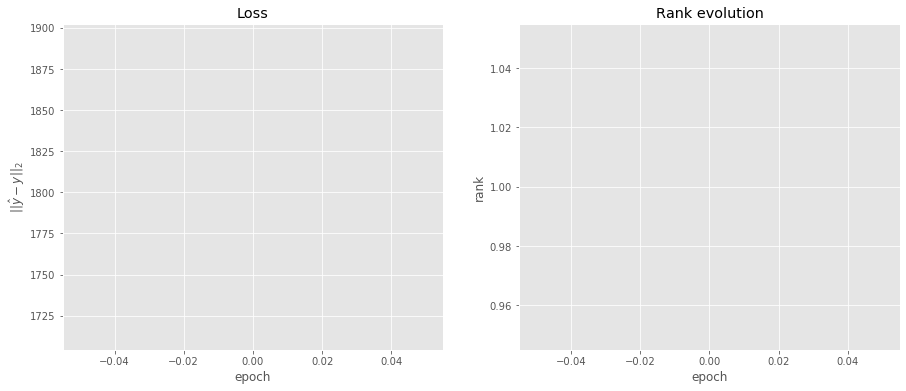

tensor([ 1.2467,  2.8965, -0.7675,  0.8203,  0.6044,  1.4845,  0.6600, -1.7190,
         2.0440, -0.2370])
tensor([ 0.2363,  1.7150, -0.1450, -1.8045,  1.7198,  0.4011, -1.4311, -2.4370,
         1.8277,  1.7370])
tensor([ 1.5210,  2.9411, -0.1298, -1.5718, -0.1501,  1.0879,  0.1036,  0.0196,
         2.5685,  1.6376])
tensor([ 0.4879,  2.1077, -1.4225, -0.5419,  1.0644,  1.9643,  0.7832, -0.9296,
         1.3038,  0.4895])
tensor([-0.7832,  0.5454, -0.5759,  1.1359, -0.2504, -0.8678,  1.5789, -2.6997,
         2.6604,  0.2928])
tensor([ 0.4376,  1.9896, -0.7953, -1.9725, -0.4398,  1.2982, -1.0130, -2.8356,
         1.1353, -0.5205])
tensor([ 1.1603,  0.2113, -0.2500,  0.1208,  0.2202,  0.3900,  1.0241, -1.9415,
         2.7663,  1.2449])
tensor([ 0.0424,  1.9056, -1.3038,  0.4103,  1.4746,  0.5176, -0.1097, -2.6867,
         0.6222,  0.4525])
tensor([ 1.7526,  2.4562, -2.8512,  0.8296,  1.8374,  2.0832,  0.2844, -0.6128,
         2.4610,  0.7984])
tensor([ 0.6893,  1.7305, -1.5276,  0

KeyboardInterrupt: 

In [43]:
loss_hist_x, rank_hist_x = train_nn(net_x, opt, loader, criterion, num_epochs=2000, with_noise=False, sigma_noise=20.)

Let's show comparison between `GD` and `Perturbed GD`

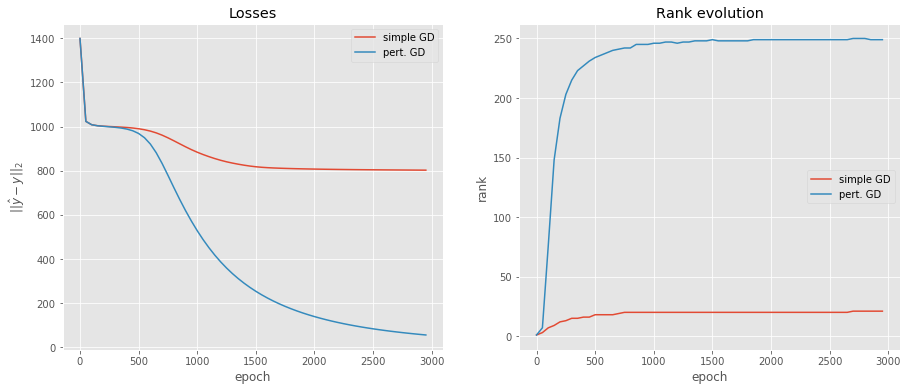

In [16]:
verbose_interval=50
plt.style.use('ggplot')
axis = range(0, verbose_interval * len(loss_hist_gd), verbose_interval)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(axis, loss_hist_gd, label='simple GD')
ax1.plot(axis, loss_hist_gd_ns, label='pert. GD')
ax1.legend()
ax1.set_title('Losses')
ax1.set_xlabel('epoch')
ax1.set_ylabel('$||\hat{y} - y||_2$')

ax2.plot(axis, rank_hist_gd, label='simple GD')
ax2.plot(axis, rank_hist_gd_ns, label='pert. GD')
ax2.legend()
ax2.set_title('Rank evolution')
ax2.set_xlabel('epoch')
ax2.set_ylabel('rank')
plt.show()

Now, let's consider linear network with Gaussian dropout, trained via `GD`

In [11]:
torch.manual_seed(42)
np.random.seed(42)
num_points=1000 
x_size=1000
y_size=250

data, R = make_random_affine_dependency_dataset(num_points, x_size, y_size, device=device)
net_drop = linearNN_dropout(x_size, y_size, widths=[250,], drop_alpha=0.2, init=10).to(device)
net_drop.train()

opt = torch.optim.SGD(net_drop.parameters(), lr=1e-2)
criterion = nn.MSELoss()
loader = DataLoader(data, batch_size=num_points, drop_last=False)

Epoch: 2950


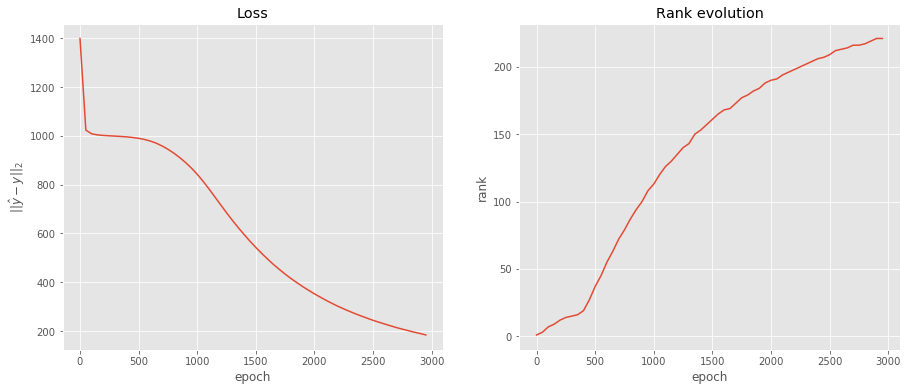

In [12]:
loss_hist_drop, rank_hist_drop = train_nn(net_drop, opt, loader, criterion, num_epochs=3000, with_noise=False, sigma_noise=20.)